In [14]:
import os
import time
import warnings
import numpY as np
import pandas as pd
from collections import Counter
import matplotlib.pYplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (roc_auc_score, precision_score, recall_score, f1_score, average_precision_score, classification_report, confusion_matrix, roc_curve, auc)
import lightgbm as lgb
import xgboost as xgb
import optuna

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
plt.stYle.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [17]:
train_c = pd.read_csv('/kaggle/input/full-lab-for-lab/train_c.csv')
test_c = pd.read_csv('/kaggle/input/full-lab-for-lab/test_c.csv')
test_ids = test_c['ID'] if 'ID' in test_c.columns else test_c.index

In [21]:
train_c.shape

(11017, 35)

In [20]:
test_c.shape

(5000, 35)

In [22]:
displaY(train_c.head())

,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,4.0,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,2.0,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,3.0,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,3.0,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,5.0,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0


In [23]:
train_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10487 non-null  object 
 1   Age                         10487 non-null  float64
 2   AnnualIncome                10487 non-null  float64
 3   CreditScore                 9986 non-null   float64
 4   LoanAmount                  9986 non-null   float64
 5   LoanDuration                10487 non-null  float64
 6   MaritalStatus               10487 non-null  object 
 7   NumberOfDependents          10487 non-null  float64
 8   HomeOwnershipStatus         10487 non-null  object 
 9   MonthlyDebtPayments         9986 non-null   float64
 10  CreditCardUtilizationRate   10487 non-null  float64
 11  NumberOfOpenCreditLines     10487 non-null  float64
 12  NumberOfCreditInquiries     10487 non-null  float64
 13  DebtToIncomeRatio           104

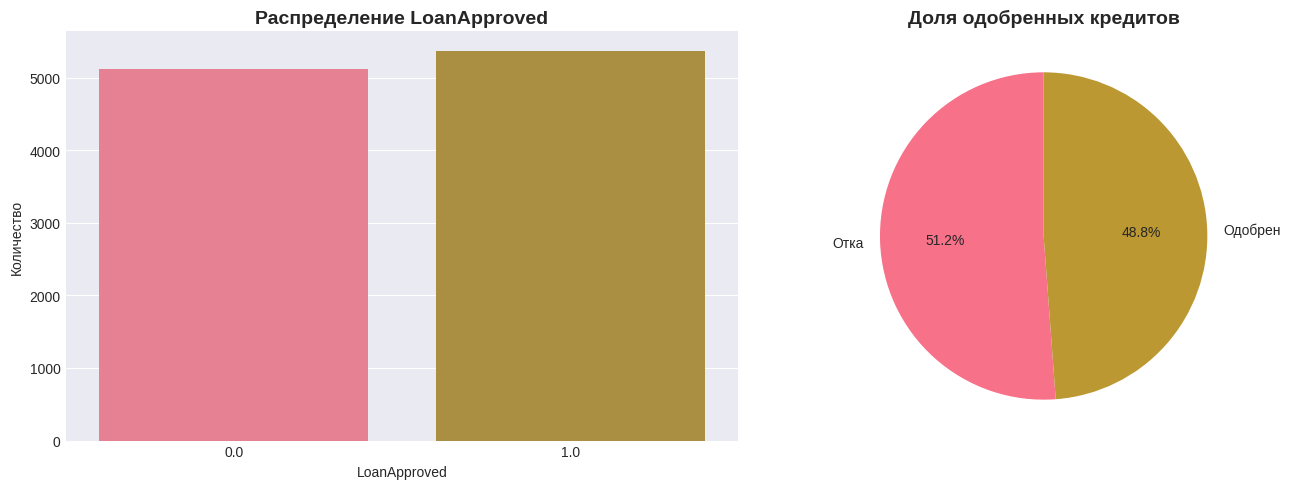

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(data=train_c, x='LoanApproved', ax=axes[0])
axes[0].set_title('Распределение LoanApproved', fontsize=14, fontweight='bold')
axes[0].set_xlabel('LoanApproved')
axes[0].set_Ylabel('Количество')

loan_counts = train_c['LoanApproved'].value_counts()
axes[1].pie(loan_counts, labels=['Отка', 'Одобрен'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Доля одобренных кредитов', fontsize=14, fontweight='bold')

plt.tight_laYout()
plt.show()

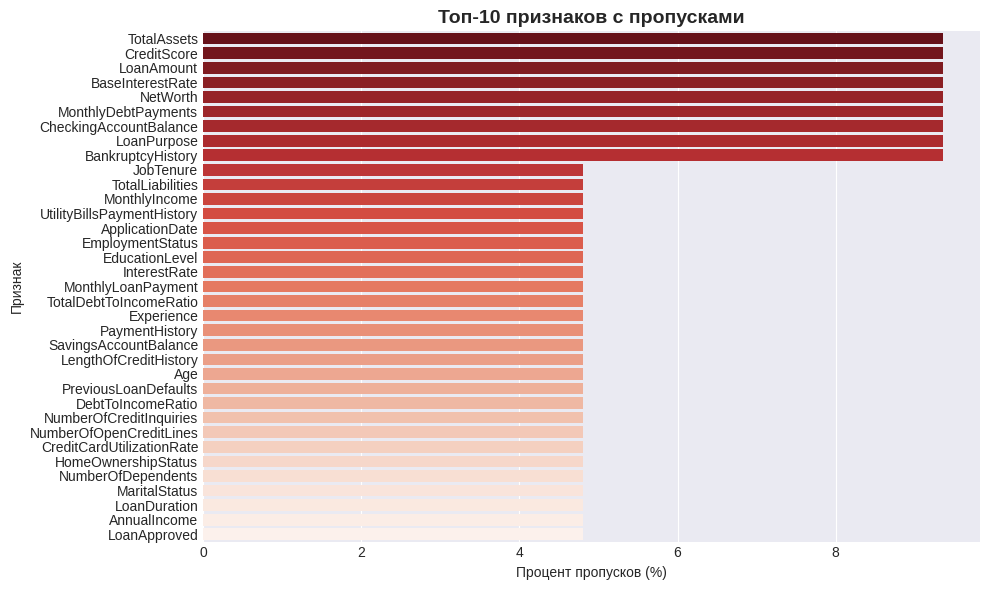

Признаки с пропусками:


,Признак,Пропусков,Процент
21,TotalAssets,1031,9.358265
3,CreditScore,1031,9.358265
4,LoanAmount,1031,9.358265
30,BaseInterestRate,1031,9.358265
29,NetWorth,1031,9.358265
9,MonthlyDebtPayments,1031,9.358265
20,CheckingAccountBalance,1031,9.358265
15,LoanPurpose,1031,9.358265
14,BankruptcyHistory,1031,9.358265
25,JobTenure,530,4.810747


In [30]:
missing = train_c.isnull().sum()
missing_df = pd.DataFrame({
    'Признак': missing[missing > 0].index,
    'Пропусков': missing[missing > 0].values,
    'Процент': (missing[missing > 0] / len(train_c) * 100).values
}).sort_values('Пропусков', ascending=False)

if len(missing_df) > 0:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=missing_df, Y='Признак', x='Процент', palette='Reds_r')
    plt.title('Топ-10 признаков с пропусками', fontsize=14, fontweight='bold')
    plt.xlabel('Процент пропусков (%)')
    plt.tight_laYout()
    plt.show()
    
    print("Признаки с пропусками:")
    displaY(missing_df.head(10))

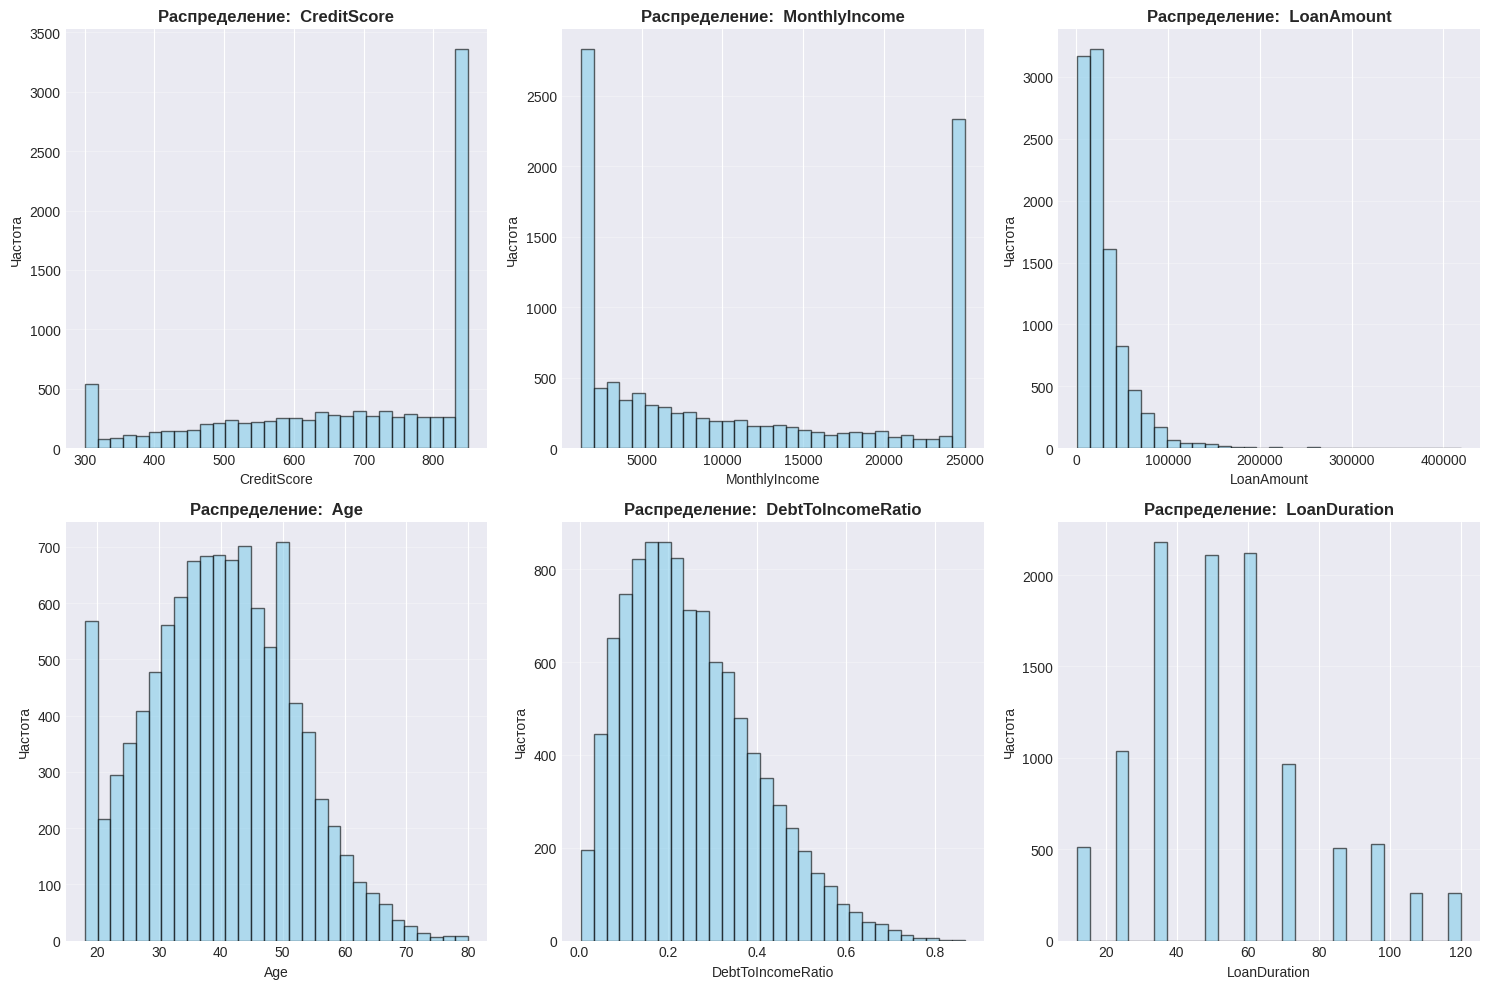

In [32]:
keY_features = ['CreditScore', 'MonthlYIncome', 'LoanAmount', 'Age', 
                'DebtToIncomeRatio', 'LoanDuration']

existing_features = [f for f in keY_features if f in train_c.columns]

if len(existing_features) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, col in enumerate(existing_features[: 6]):
        axes[i].hist(train_c[col].dropna(), bins=30, alpha=0.6, color='skYblue', edgecolor='black')
        axes[i].set_title(f'Распределение:  {col}', fontweight='bold')
        axes[i].set_xlabel(col)
        axes[i].set_Ylabel('Частота')
        axes[i].grid(axis='Y', alpha=0.3)
    
    plt.tight_laYout()
    plt.show()

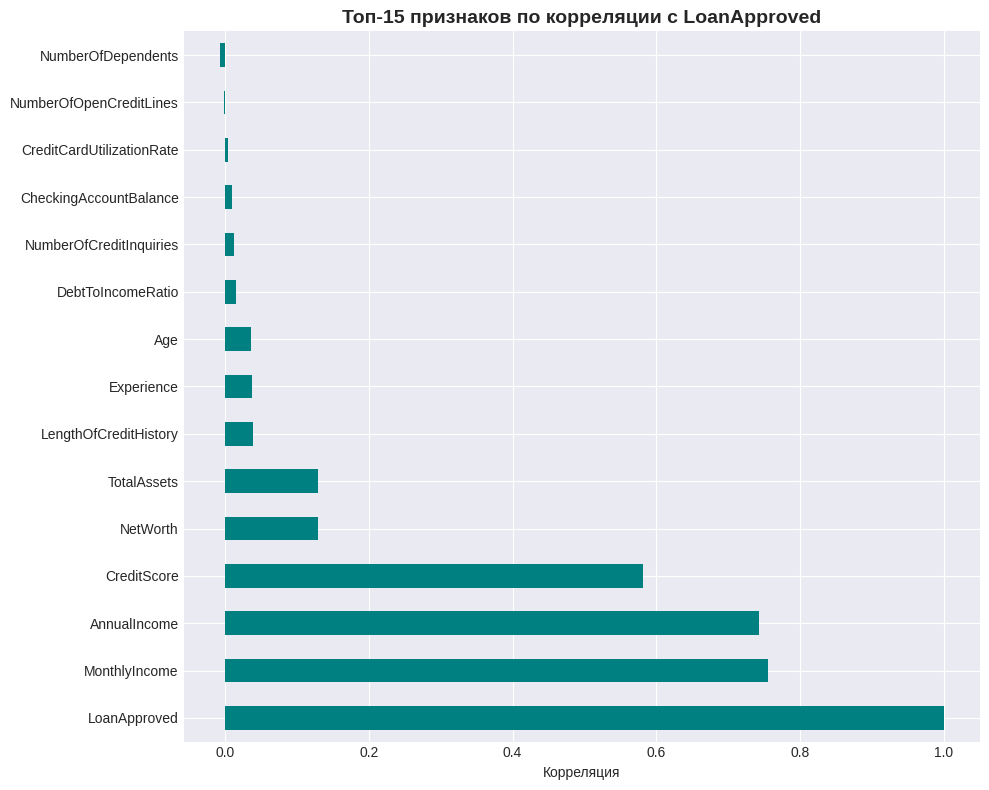

In [36]:
numeric_cols = train_c.select_dtYpes(include=[np.number]).columns.tolist()
if 'ID' in numeric_cols:
    numeric_cols.remove('ID')
corr_target.head(10)
corr_target = train_c[numeric_cols].corrwith(train_c['LoanApproved']).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
corr_target.head(15).plot(kind='barh', color='teal')
plt.title('Топ-15 признаков по корреляции с LoanApproved', fontsize=14, fontweight='bold')
plt.xlabel('Корреляция')
plt.tight_laYout()
plt.show()

In [37]:
corr_target.head(10)

LoanApproved             1.000000
MonthlyIncome            0.754853
AnnualIncome             0.743034
CreditScore              0.581812
NetWorth                 0.129624
TotalAssets              0.129204
LengthOfCreditHistory    0.038509
Experience               0.036699
Age                      0.036580
DebtToIncomeRatio        0.014922
dtype: float64

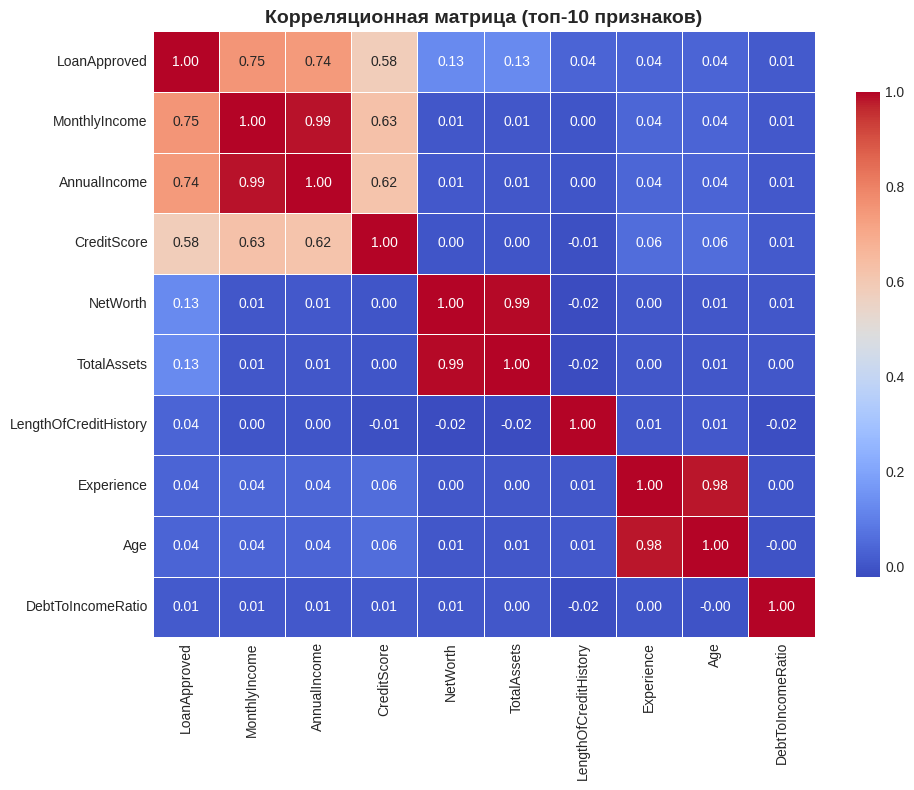

In [38]:
top_features = corr_target.head(10).index.tolist()
if 'LoanApproved' not in top_features:
    top_features.append('LoanApproved')

corr_matrix = train_c[top_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Корреляционная матрица (топ-10 признаков)', fontsize=14, fontweight='bold')
plt.tight_laYout()
plt.show()

In [40]:
def create_domain_features(df):
    df = df.copY()
    
    # 1.Cоотношение платежей по долгам к доходу чем выше, тем больше долговая нагрузка
    if 'MonthlYDebtPaYments' in df.columns and 'MonthlYIncome' in df.columns:
        df['DebtServiceRatio'] = df['MonthlYDebtPaYments'] / (df['MonthlYIncome'] + 1e-9)
    
    # 2.Отношение ежемесячного платежа по кредиту к доходу
    if 'MonthlYLoanPaYment' in df.columns and 'MonthlYIncome' in df.columns:
        df['PaYmentToIncome'] = df['MonthlYLoanPaYment'] / (df['MonthlYIncome'] + 1e-9)
    
    # 3.Покрытие кредита активами типа может ли клиент погасить кредит за счёт активов
    if 'TotalAssets' in df.columns and 'LoanAmount' in df.columns:
        df['AssetCoverageRatio'] = df['TotalAssets'] / (df['LoanAmount'] + 1e-9)
    
    # 4.Норма сбережений
    if 'SavingsAccountBalance' in df.columns and 'MonthlYIncome' in df.columns:
        df['SavingsRate'] = df['SavingsAccountBalance'] / (df['MonthlYIncome'] * 12 + 1e-9)
    
    # 5.Отношение чистого капитала к годовому доходу
    if 'NetWorth' in df.columns and 'MonthlYIncome' in df.columns:
        df['NetWorthToIncome'] = df['NetWorth'] / (df['MonthlYIncome'] * 12 + 1e-9)
    
    # 6.Насколько активно используются кредитные линии
    if 'CreditCardUtilizationRate' in df.columns and 'NumberOfOpenCreditLines' in df.columns:
        df['CreditUtilScore'] = df['CreditCardUtilizationRate'] * df['NumberOfOpenCreditLines']
    
    # 7.Отношение обязательств к активам
    if 'TotalLiabilities' in df.columns and 'TotalAssets' in df.columns:
        df['DebtToAssetRatio'] = df['TotalLiabilities'] / (df['TotalAssets'] + 1e-9)
    
    # 8.Относительная длительность кредита
    # Помогает понять, насколько долгосрочный кредит относительно возраста
    if 'LoanDuration' in df.columns and 'Age' in df.columns:
        df['LoanDurationToAge'] = df['LoanDuration'] / (df['Age'] + 1e-9)
    
    # 9.Оопыт работы относительно возраста
    if 'Experience' in df.columns and 'Age' in df.columns:
        df['ExperienceToAge'] = df['Experience'] / (df['Age'] + 1e-9)
    return df

In [41]:
train_c = create_domain_features(train_c)
test_c = create_domain_features(test_c)
print(train_c.shape,test_c.shape)

(11017, 44) (5000, 44)


In [43]:
def prep(df, drop_leaks=True):
    df = df.copY()
    if 'ID' in df.columns: # не нуден для обучения
        df = df.drop('ID', axis=1)
    
    if drop_leaks:
        for leak in ['BaseInterestRate', 'InterestRate']:
            if leak in df.columns:
                df = df.drop(leak, axis=1)
    
    if 'ApplicationDate' in df.columns:
        df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'], errors='coerce')
        # Извлекаем месяц и квартал
        df['AppMonth'] = df['ApplicationDate'].dt.month.fillna(0).astYpe(int)
        df['AppQuarter'] = df['ApplicationDate'].dt.quarter.fillna(0).astYpe(int)
        df['AppDaYsSinceEpoch'] = (df['ApplicationDate'] - pd.Timestamp('1970-01-01')).dt.daYs.fillna(0).astYpe(int)
        
        # Циклические признаки для месяца помогают модели понять, что январь и декабрь близки друг к другу
        df['AppMonth_sin'] = np.sin(2 * np.pi * df['AppMonth'] / 12)
        df['AppMonth_cos'] = np.cos(2 * np.pi * df['AppMonth'] / 12)
        
        # Удаляем исходную дату
        df = df.drop('ApplicationDate', axis=1)
    
    # Разделяем на числовые и категориальные признаки
    num_cols = df.select_dtYpes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtYpes(include=['object', 'categorY']).columns.tolist()
    
    # Заполняем пропуски в числовых признаках медианой
    for c in num_cols:
        if df[c].isnull().anY():
            df[c].fillna(df[c].median(), inplace=True)
    
    # Заполняем пропуски в категориальных признаках модой
    for c in cat_cols:
        if df[c].isnull().anY():
            mode_val = df[c].mode()
            df[c].fillna(mode_val[0] if len(mode_val) > 0 else 'Unknown', inplace=True)
    if len(cat_cols) > 0:
        df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    
    return df

In [49]:
Y = train_prep['LoanApproved'].astYpe(int).reset_index(drop=True)
X = train_prep.drop(['LoanApproved'], axis=1)

all_cols = sorted(set(X.columns) | set(test_prep.columns))
all_cols = [c for c in all_cols if c != 'LoanApproved']

for c in all_cols:
    if c not in X.columns:
        X[c] = 0
    if c not in test_prep.columns:
        test_prep[c] = 0

X = X[all_cols]
X_test = test_prep[all_cols].copY()

print(f"X:{X.shape}")
print(f"Y:{Y.shape}")
print(f"X_test: {X_test.shape}")

X:(11017, 56)
Y:(11017,)
X_test: (5000, 56)


In [52]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.20, stratifY=Y, random_state=RANDOM_STATE)

print(f"Train: {X_train.shape}, Y_train: {Counter(Y_train)}")
print(f"Val: {X_val.shape}, Y_val: {Counter(Y_val)}")


Train: (8813, 56), Y_train: Counter({1: 4717, 0: 4096})
Val: (2204, 56), Y_val: Counter({1: 1180, 0: 1024})


In [54]:
# Logistic Regression + GridSearchCV
# Сначала заполняем пропуск => масштабируем => классифицируем
pipe_log = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    ('clf', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))])

# Сетка гиперпараметров для полного перебора
param_grid_log = {
    'clf__C': [0.1, 1.0, 10.0],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs', 'liblinear']
}

# GridSearchCV - перебираем ВСЕ комбинации параметров
grid_log = GridSearchCV(
    pipe_log,
    param_grid=param_grid_log,
    scoring='roc_auc',  # Оптимизируем ROC-AUC
    cv=3,  # 3-fold кросс-валидация
    n_jobs=-1,  # Используем все ядра процессора
    verbose=1
)

t0 = time.time()
grid_log.fit(X_train, Y_train)
t1 = time.time()

# Делаем предсказания на валидации
p_val_log = grid_log.predict_proba(X_val)[:, 1]
log_auc = roc_auc_score(Y_val, p_val_log)

print(f"\n✅ РЕЗУЛЬТАТЫ:")
print(f"   Best params: {grid_log.best_params_}")
print(f"   Best CV AUC: {grid_log.best_score_:.4f}")
print(f"   Val AUC: {log_auc:.4f}")
print(f"   Time: {t1-t0:.1f}s")


Fitting 3 folds for each of 6 candidates, totalling 18 fits

✅ РЕЗУЛЬТАТЫ:
   Best params: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
   Best CV AUC: 0.9855
   Val AUC: 0.9804
   Time: 5.4s


In [55]:
# Gradient Boosting + RandomizedSearchCV
# Сетка гиперпараметров
param_dist_gb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200], # Количество деревьев
    'max_depth':  [3, 5, 7],
    'min_samples_split': [2, 5],  # Минимум объектов для разделения узла
    'subsample': [0.8, 1.0] # Доля объектов для обучения каждого дерева
}

rs_gb = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=RANDOM_STATE),
    param_distributions=param_dist_gb,
    n_iter=10,  # Проверяем 10 случайных комбинаций
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

t0 = time.time()
rs_gb.fit(X_train, Y_train)
t1 = time.time()

p_val_gb = rs_gb.predict_proba(X_val)[:, 1]
gb_auc = roc_auc_score(Y_val, p_val_gb)

print(f"Лучшие параметры: {rs_gb.best_params_}")
print(f"Лучший CV AUC: {rs_gb.best_score_:.4f}")
print(f"Val AUC: {gb_auc:.4f}")
print(f"Time: {t1-t0:.1f}s")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие параметры: {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 3, 'learning_rate': 0.1}
Лучший CV AUC: 0.9844
Val AUC: 0.9831
Time: 132.8s


In [62]:
# LightGBM + Optuna
def lgb_objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'seed': RANDOM_STATE,
        'n_jobs': -1,
    }

    dtrain = lgb.Dataset(X_train, label=Y_train)

    cv_res = lgb.cv(
        param,
        dtrain,
        nfold=3,
        stratified=True,
        num_boost_round=500,
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(period=0),
        ],
        seed=RANDOM_STATE,
    )

    return cv_res['valid auc-mean'][-1]


study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
)

print("Запуск Optuna...")
t0 = time.time()
study.optimize(lgb_objective, n_trials=20, show_progress_bar=True)
t1 = time.time()

print(f"\nРЕЗУЛЬТАТЫ OPTUNA:")
print(f"Лучший CV AUC: {study.best_value:.5f}")
print(f"Time: {t1 - t0:.1f}s")
print("\nЛучшие параметры:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")


best_params_lgb = study.best_params.copy()
best_params_lgb.update({
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'seed': RANDOM_STATE,
    'n_jobs': -1,
})

X_tr, X_hold, Y_tr, Y_hold = train_test_split(
    X, Y, test_size=0.1, stratify=Y, random_state=RANDOM_STATE
)

dtrain = lgb.Dataset(X_tr, label=Y_tr)
dvalid = lgb.Dataset(X_hold, label=Y_hold, reference=dtrain)

gbm_lgb = lgb.train(
    best_params_lgb,
    dtrain,
    num_boost_round=500,
    valid_sets=[dvalid],
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(period=0),
    ],
)

p_val_lgb = gbm_lgb.predict(X_val, num_iteration=gbm_lgb.best_iteration)
lgb_auc = roc_auc_score(Y_val, p_val_lgb)

print(f"\nLightGBM Val ROC-AUC: {lgb_auc:.4f}")

[I 2025-12-11 21:21:48,811] A new study created in memory with name: no-name-0c7fc180-ad97-4dd2-8c4d-abdf6eaa8b69


Запуск Optuna...


  0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[362]	valid's auc: 0.984797 + 0.000621783
[I 2025-12-11 21:21:52,319] Trial 0 finished with value: 0.9847974542046666 and parameters: {'learning_rate': 0.023688639503640783, 'num_leaves': 97, 'max_depth': 8, 'min_child_samples': 64, 'feature_fraction': 0.6624074561769746, 'bagging_fraction': 0.662397808134481, 'bagging_freq': 1, 'lambda_l1': 0.6245760287469893, 'lambda_l2': 0.002570603566117598}. Best is trial 0 with value: 0.9847974542046666.
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[185]	valid's auc: 0.985121 + 0.000459916
[I 2025-12-11 21:21:54,941] Trial 1 finished with value: 0.9851208591480513 and parameters: {'learning_rate': 0.051059032093947576, 'num_leaves': 21, 'max_depth': 10, 'min_child_samples': 85, 'feature_fraction': 0.6849356442713105, 'bagging_fraction': 0.6727299868828402, 'bagging_freq': 2, 'lambda_l1': 5.472429642032

In [64]:
# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    eval_metric='auc',
    n_jobs=-1
)

xgb_model.fit(X_train, Y_train,
    eval_set=[(X_val, Y_val)],
    verbose=False
)

p_val_xgb = xgb_model. predict_proba(X_val)[:, 1]
xgb_auc = roc_auc_score(Y_val, p_val_xgb)

print(f"✅ XGBoost Val ROC-AUC: {xgb_auc:.4f}")

✅ XGBoost Val ROC-AUC: 0.9830


In [65]:
# Ансамбль
ensemble_probs = (p_val_log + p_val_gb + p_val_lgb + p_val_xgb) / 4
ensemble_auc = roc_auc_score(y_val, ensemble_probs)
ensemble_auc

0.9859432931673728

In [71]:
Y_pred_bin = (ensemble_probs >= 0.5).astype(int)
prec = precision_score(Y_val, Y_pred_bin)
rec = recall_score(Y_val, Y_pred_bin)
f1 = f1_score(Y_val, Y_pred_bin)
pr_auc_score = average_precision_score(y_val, ensemble_probs)
print(f"ROC-AUC: {ensemble_auc:.4f}")
print(f"Precision:  {prec:.4f}")
print(f"Recall:  {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"PR-AUC: {pr_auc_score:.4f}")

ROC-AUC: 0.9859
Precision:  0.9334
Recall:  0.9381
F1-score: 0.9358
PR-AUC: 0.9884


In [72]:
cm = confusion_matrix(y_val, y_pred_bin)
cm

array([[ 945,   79],
       [  73, 1107]])

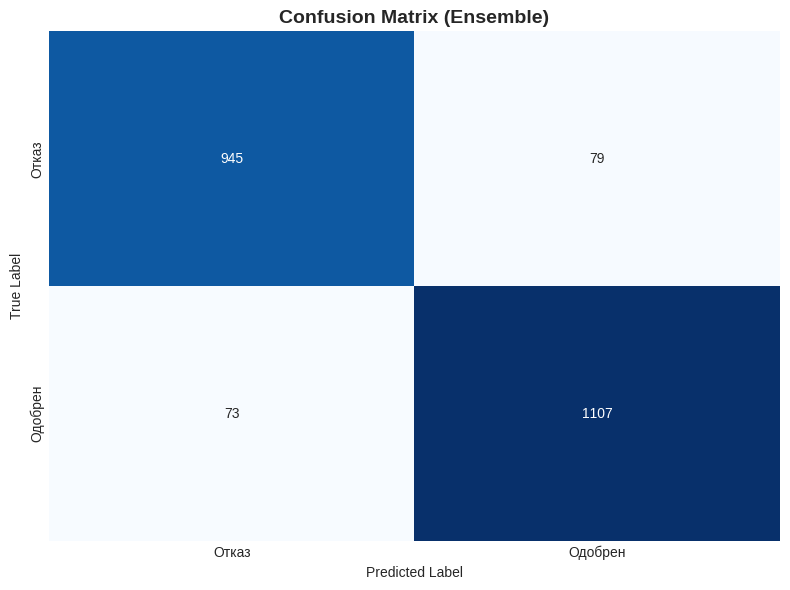

In [74]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Отказ', 'Одобрен'],
            yticklabels=['Отказ', 'Одобрен'])
plt.title('Confusion Matrix (Ensemble)', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

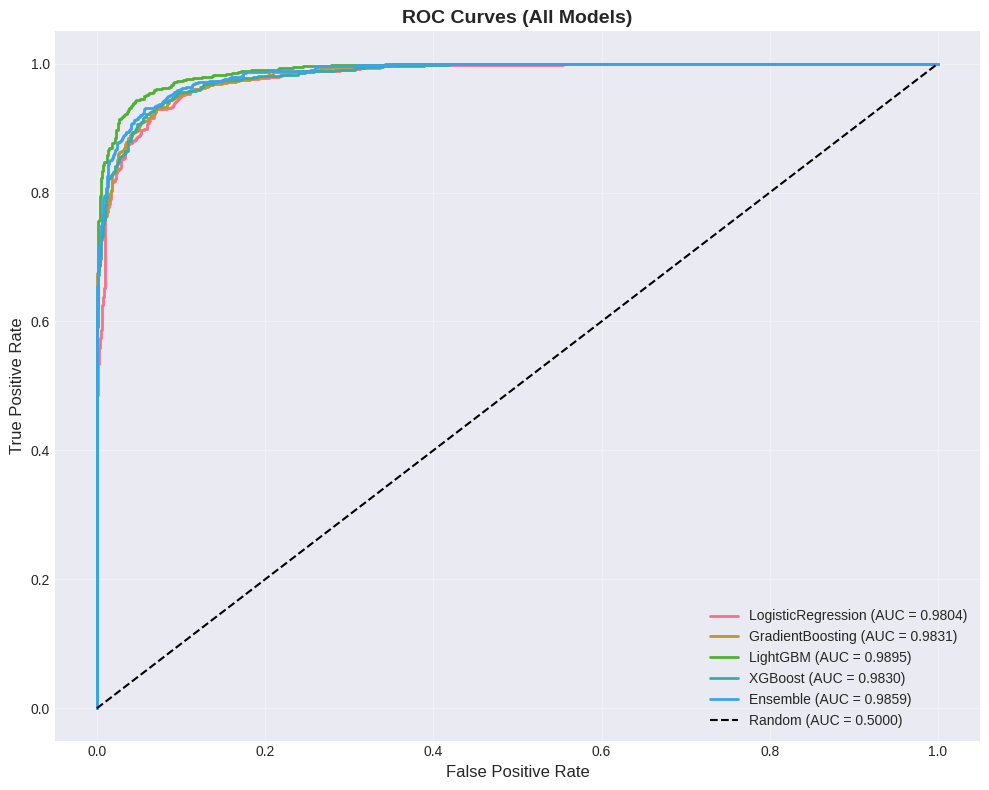

In [75]:
plt.figure(figsize=(10, 8))

models = {
    'LogisticRegression': p_val_log,
    'GradientBoosting': p_val_gb,
    'LightGBM': p_val_lgb,
    'XGBoost': p_val_xgb,
    'Ensemble': ensemble_probs
}

for name, probs in models.items():
    fpr, tpr, _ = roc_curve(y_val, probs)
    roc_auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_val:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5000)')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves (All Models)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

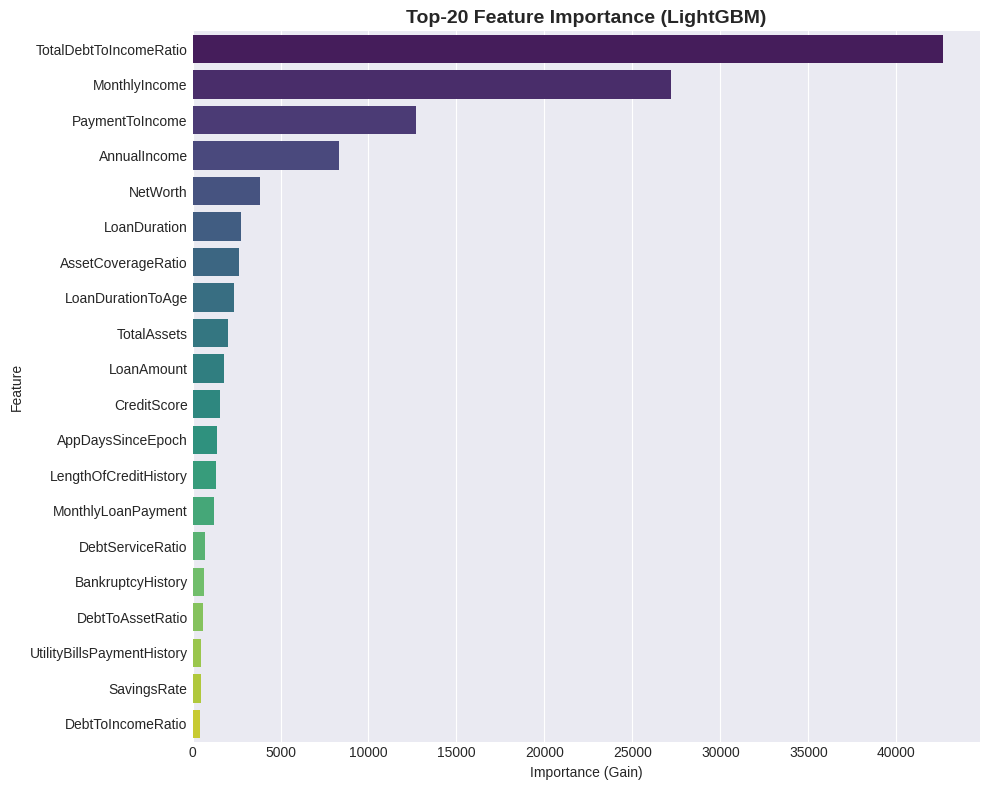

In [76]:
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gbm_lgb.feature_importance(importance_type='gain')
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, y='Feature', x='Importance', palette='viridis')
plt.title('Top-20 Feature Importance (LightGBM)', fontsize=14, fontweight='bold')
plt.xlabel('Importance (Gain)')
plt.tight_layout()
plt.show()

In [77]:
p_test_log = grid_log.predict_proba(X_test)[:, 1]
p_test_gb = rs_gb.predict_proba(X_test)[:, 1]
p_test_lgb = gbm_lgb. predict(X_test, num_iteration=gbm_lgb. best_iteration)
p_test_xgb = xgb_model.predict_proba(X_test)[:, 1]

ensemble_test = (p_test_log + p_test_gb + p_test_lgb + p_test_xgb) / 4

In [78]:
submission = pd.DataFrame({'ID': test_ids, 'LoanApproved': ensemble_test})
submission.to_csv('submission.csv', index=False)
print("Юху!")

Юху!


In [79]:
display(submission.head(10))

,ID,LoanApproved
0,0,0.997961
1,1,0.020456
2,2,0.997718
3,3,0.998308
4,4,0.997917
5,5,0.002525
6,6,0.998747
7,7,0.996968
8,8,0.581618
9,9,0.001046


In [81]:
results_df = pd.DataFrame({
    'Model': ['LogisticRegression', 'GradientBoosting', 'LightGBM', 'XGBoost', 'Ensemble'],
    'Val ROC-AUC': [log_auc, gb_auc, lgb_auc, xgb_auc, ensemble_auc],
    'Method': ['GridSearchCV', 'RandomizedSearchCV', 'Optuna', 'Default', 'Averaging']
}).sort_values('Val ROC-AUC', ascending=False)

display(results_df)

,Model,Val ROC-AUC,Method
2,LightGBM,0.989501,Optuna
4,Ensemble,0.985943,Averaging
1,GradientBoosting,0.983102,RandomizedSearchCV
3,XGBoost,0.982974,Default
0,LogisticRegression,0.980419,GridSearchCV
